# smote_L1_L2_Syndigo Mapping ML
  - module name: smote_L1_L2_Syndigo ML.ipynb
  - Purpose: Combine Level 1 & Level 2 from  Syndigo to build model
             - Apply TFIDF and W2vec imbedding methods 
  - Excluding non-item SUBCOMs from un-label data and including  ‘stratify= y’ when I did train_test_split.       
  - Basse on adj_typ to iInclude SMOTE for imbalance data 
    -adj_typ
      - no_smote: no adjustment
      - smote : Apply SMOTE(k_neighbors =1) for oversample
      - smote_undsmp:   Apply SMOTE(k_neighbors =1) for oversample and RandomUnderSampler() for undersample 
     - The function 'prepare_data_2' will base on adj_typ to create X, y for modeling   
      
   - Notes:
     - In order to apply ‘stratify= y’ in train_test_split,   
       - The code needs to drop count of y  = 1. PLease  refer to the function 'prepare_data_2'  
       - it needs to define k_neighbors = 1 for SMOTE
     - Will focus on W2vec only

In [1]:
def prepare_data_1():
    pgm = inspect.currentframe().f_code.co_name  
    start_time = time.time() 
    # Reading PIMMART data
    pim_gtin_mapped = pd.read_csv(DBFR + "PIM_Data_New_50_82Mn.csv", dtype=object) # (5082212, 24)

    SUBCOMS_excluded = ['INVENTORY VALUES','MISC SALES TRANS','MISC SALES TRANS (NON TAX)','CENTRAL SUPPLIES', \
                        'MISC SALES TRANS (TX TAXABLE)','COUPON','MISCELLANEOUS INCOME','CRV/EXCISE TAX NT/NF', \
                        'CRV DEPOSIT NT/F','CRV DEPOSIT T/NF','MISCELLANEOUS REFUNDS','CUSTOMER EXPENSES','ROUND UP COUPONS']
    pim_gtin_mapped = pim_gtin_mapped[~pim_gtin_mapped.SUBCOM_DSC.isin(SUBCOMS_excluded)]
    print(f'Before drop pim_gtin_mapped.shape {pim_gtin_mapped.shape}')
    print(f'After drop pim_gtin_mapped.shape {pim_gtin_mapped.shape}')
    for i in ['SUBCOM_CD', 'DPT_CD', 'COM_CD','PMY_DPT_CD', 'REC_DPT_CD', 'ITM_ID', 'GTIN']:
        pim_gtin_mapped[i] = pim_gtin_mapped[i].astype(np.float64)
    
    # Reading Syndigo 259K data
    synd_ALL = pd.read_csv(DBFR + 'Syndigo_Final_ALL.csv', dtype='unicode') # 259k Syndigo Data
    for i in ['SUBCOM_CD', 'DPT_CD', 'COM_CD', 'GTIN', 'ITM_ID', 'PMY_DPT_CD']:
        synd_ALL[i] = synd_ALL[i].astype(np.float64)
    
    # Stripping spaces from all columns
    df_obj = synd_ALL.select_dtypes(['object'])
    synd_ALL[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    
    syndigo_mapped = synd_ALL
    pimmart = pim_gtin_mapped
    syndigo_mapped.drop_duplicates('GTIN', inplace = True)

    
    syndigo_mapped['ITEM_SUBCOM_text'] = \
    (syndigo_mapped.VND_ECOM_DSC + ' ' + syndigo_mapped.SUBCOM_DSC).fillna('').str.lower()
    #syndigo_mapped['Level 1'].value_counts()
    #print(f'syndigo_mapped.shape {syndigo_mapped.shape}') 
    #print(f'syndigo_mapped.info() {syndigo_mapped.info()}') 
    #print(f'syndigo_mapped.head() {syndigo_mapped.head()}') 
    #print(f'syndigo_mapped.columns {syndigo_mapped.columns}') 
    
    syndigo_mapped['l1_l2'] = syndigo_mapped['Level 1'] + ' + ' + syndigo_mapped['Level 2']
    #print(f"syndigo_mapped['l1_l2'].value_counts() {syndigo_mapped['l1_l2'].value_counts(dropna = False)}")    
    return syndigo_mapped, pim_gtin_mapped

In [44]:
def prepare_data_2(samp_frac = 1, embed_typ):
  
    start_time = time.time()
    pgm = inspect.currentframe().f_code.co_name 
    global syndigo_mapped, model
    print(f' samp_frac = {samp_frac}') 
    syndigo_mapped = syndigo_mapped_bkup.copy()    
    print (f'Before sample syndigo_mapped.shape {syndigo_mapped.shape }')
           
    whole_frac = 1
    if samp_frac  < whole_frac :   syndigo_mapped = syndigo_mapped.sample(frac = samp_frac,  random_state=42)   
    print (f'After sample syndigo_mapped.shape {syndigo_mapped.shape }')    
    
    
    series = syndigo_mapped['l1_l2'].value_counts(ascending=True)
    if series.tolist():
       syndigo_mapped = syndigo_mapped.drop(syndigo_mapped[syndigo_mapped['l1_l2'].isin(series[series < 3 ].index.tolist())].index)
       print (f'after drop syndigo_mapped.shape {syndigo_mapped.shape }')                     
    
    if embed_typ == 'tfidf': 
        print(f'embed_typ == 'tfidf')
        vect = TfidfVectorizer(ngram_range = (1,2), max_features = 50000) 
        X = vect.fit_transform(syndigo_mapped.ITEM_SUBCOM_text) #scipy.sparse._csr.csr_matrix
    else:
        print(f'embed_typ == 'W2vec')              
        model = KeyedVectors.load_word2vec_format(DBFO + 'w2vmodel_053123_PIM_ALL.bin', binary=True)
        X = np.array(list(syndigo_mapped.ITEM_SUBCOM_text.apply(lambda x: get_item_vector(x.split(' ')))))

    l1_l2_id_map = dict(zip(syndigo_mapped['l1_l2'].fillna('Other').unique(), range(syndigo_mapped['l1_l2'].fillna('Other').nunique())))
    id_l1_l2_map = dict(zip(range(syndigo_mapped['l1_l2'].fillna('Other').nunique()), syndigo_mapped['l1_l2'].fillna('Other').unique()))
    y  = syndigo_mapped['l1_l2'].fillna('Other').map(l1_l2_id_map) 
           
    counter = Counter(y)
    for k,v in counter.items():
        per = v / len(y) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    pyplot.bar(counter.keys(), counter.values())
    pyplot.show()           
    #y_list= list(y)
    #y = pd.Series(list(filter (lambda z: y_list.count(z) > 1, y_list)))
    #
    end_time = time.time()   
    desc = f' Elapse_time for "{pgm}".' 
    elapse_time (  start_time, end_time, desc)
    return  X, y, l1_l2_id_map, id_l1_l2_map

SyntaxError: unterminated string literal (detected at line 21) (4084535122.py, line 21)

In [3]:
#Build item vectors
def get_item_vector(item_vocab):
    vect = np.zeros_like(model.get_vector('chips'))
    for word in item_vocab:
        if word in model:
            vect += model.get_vector(word)
    return vect#/max(1,len(item_vocab))

In [39]:
def proc_predict(test_size,c_parm, embed_typ, adj_typ):
     start_time = time.time()
     pgm = inspect.currentframe().f_code.co_name   
     global A_train, A_test, B_train, B_test, X_train, X_test, y_train, y_test
     A_train, A_test, B_train, B_test = train_test_split(syndigo_mapped.GTIN.tolist(), syndigo_mapped['l1_l2'].tolist(), test_size=test_size,  random_state=42, stratify= y)
     
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size,  random_state=42, stratify= y)

     if adj_typ == 'no_smote': pass
     elif  adj_typ == 'smote':
        oversample = SMOTE(k_neighbors =1)  
        X_train, y_train  = oversample.fit_resample(X_train, y_train) 
        A_train =  np.array(A_train).reshape(-1, 1)
        A_train, B_train  = oversample.fit_resample(A_train, B_train) 
     elif  adj_typ == 'smote_undsmp':
        over = SMOTE(k_neighbors = 1)
        under = RandomUnderSampler()
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        X_train, y_train  = pipeline.fit_resample(X_train, y_train )
        A_train =  np.array(A_train.reshape(-1, 1))
        A_train, B_train  = pipeline.fit_resample(A_train, B_train )
     else: pass        
    
     print(f'Build model for  embed_typ {embed_typ} and  adj_typ {adj_typ}; len  of y_train = {len(y_train)}, len  of B_train = {len(B_train)}'  ) 
     lr_tf = LogisticRegression(C = c_parm, multi_class = 'multinomial', solver = 'saga', n_jobs=-1)
     
     print(f"Training starts for test_size = {test_size}, c_parm = {c_parm} ")
     lr_tf.fit(X_train, y_train)
     preds = lr_tf.predict(X_test)
     #print(f"type(preds) {type(preds)} len(preds) {len(preds)} \n preds[0:10] {preds[0:10]}")
     preds_lrtf = preds
     probs = lr_tf.predict_proba(X_test)
     #print(f"type(probs) {type(probs)} len(probs) {len(probs)} \n probs[0:10] {probs[0:10]}")   
     preds_train = lr_tf.predict(X_train)
     #print(f"type(preds_train) {type(preds_train)} len(preds_train) {len(preds_train)} \n preds_train[0:10] {preds_train[0:10]} ")   
     probs_train = lr_tf.predict_proba(X_train)
     #print(f"type(probs_train) {type(probs_train)} len(probs_train) {len(probs_train)} \n probs_train[0:10] {probs_train[0:10]}")   
     #print(classification_report(y_test, preds_test,labels = lr_tf.classes_, target_names = [id2_level_map[i] for i in lr_tf.classes_]))
     
    
    
     #print("Accuracy = ",accuracy_score(y_test,preds))
     #print("Display TFIDF metrics")
     #print(classification_report(y_test, preds,labels = lr_tf.classes_, target_names = [id_l1_l2_map[i] for i in lr_tf.classes_]))
     filename = path + f'L1_l2_LR_{embed_typ}_{adj_typ}.pkl'
   
     pickle.dump(lr_tf, open(filename, 'wb'))

     print(f"Done Training ")
     end_time = time.time()   
     desc = f' Elapse_time for "{pgm}".' 
     elapse_time (  start_time, end_time, desc)
     return preds, preds_lrtf, probs, preds_train, probs_train, lr_tf

In [26]:
def validation(test_size, c_parm, embed_typ, adj_typ):
     start_time = time.time() 
     pgm = inspect.currentframe().f_code.co_name
     global f1_score_weighted, f1_score_macro,f1_score_micro 
     l_metrics = []
     print(f'Validation for c_parm = {c_parm}, test_size = {test_size}, and embed_type {embed_typ} ' ) 
     accuracy = accuracy_score(y_test,preds)
     print(f"Accuracy Score = {accuracy}")
     
     f1_score_weighted = f1_score(y_test, preds, average="weighted")
     f1_score_macro    = f1_score(y_test, preds, average='macro')
     f1_score_micro    = f1_score(y_test, preds, average='micro')  
     print (f" f1_score_weighted = {f1_score_weighted}")
     print (f" f1_score_macro    = {f1_score_macro   }")
     print (f" f1_score_micro    = {f1_score_micro   }")
     # Compute the Multiclass ROC AUC score
     #multi_class = 'multinomial'
     #score = roc_auc_score(y_test, preds, multi_class= multi_class)
     #print(f"ROC AUC score for Multiclass= {multi_class}: {score:.2f}")

     print("Display metrics")
     test_metrics = pd.DataFrame(classification_report(y_test, preds,labels = lr_tf.classes_, target_names = [id_l1_l2_map[i] for i in lr_tf.classes_],  output_dict= True)).T
     #test_metrics = pd.DataFrame(classification_report(results_test.Actuals, results_test.Predictions, output_dict= True)).T 
     #print(test_metrics)
     #Stest_metrics.to_csv('L1_L2_Test_Metrics_yue.csv')
     #accuracy = 1
     tab_name = f'{embed_typ}_L1_L2_cls_rpr_{adj_typ}'   
     print(f'tab_name = {tab_name}')  
     l_metrics = [embed_typ, adj_typ, test_size, c_parm, accuracy, f1_score_weighted, f1_score_macro,f1_score_micro ]
     end_time = time.time()   
     desc = f' Elapse_time for "{pgm}".' 
     elapse_time (  start_time, end_time, desc)    
     return test_metrics, tab_name, l_metrics 
                               

In [9]:
def proc_append():
    start_time = time.time()
    pgm = inspect.currentframe().f_code.co_name     
    test_new_proobs = []
    
    #print(f'len(preds)  {len(preds)}')
    for i in range(len(preds)):
        test_new_proobs.append(probs[i][np.argsort(probs[i])][::-1][:1].tolist())
    test_new_proobs = [element for sublist in list(test_new_proobs) for element in sublist]
    #print(f'test_new_proobs {test_new_proobs}')
    
    train_new_proobs = []
    
    #print(f'len(preds_train)  {len(preds_train)}')
    for i in range(len(preds_train)):
         test_new_proobs.append(probs_train[i][np.argsort(probs_train[i])][::-1][:1].tolist())
    train_new_proobs = [element for sublist in list(train_new_proobs) for element in sublist]
    #print(f'train_new_proobs {train_new_proobs}')  
    
    # process testLevels & trainLevelss 
    testLevels = []
    for j in y_test:
        testLevels.append([i for i in l1_l2_id_map if l1_l2_id_map[i]==j][0])
    #print(f'testLevels {testLevels [0:10]}')
    testLevelss = []
    for j in preds:
        testLevelss.append([i for i in l1_l2_id_map if l1_l2_id_map[i]==j][0])
    #print(f'testLevelss {testLevelss [0:10]}')
    
    trainLevelss = []
    for j in preds_train:
        trainLevelss.append([i for i in l1_l2_id_map if l1_l2_id_map[i]==j][0])
     
    end_time = time.time()   
    desc = f' Elapse_time for "{pgm}".' 
    elapse_time (  start_time, end_time, desc)    
    return  test_new_proobs, train_new_proobs, testLevels, testLevelss, trainLevelss

In [10]:
def proc_cr_df(test_size, c_parm, embed_typ, adj_typ):

    start_time = time.time()
    pgm = inspect.currentframe().f_code.co_name 
    print("---------------------------------------------\FINAL COUNTS:\n---------------------------------------------")
    print("1)", len(A_test + A_train))
    print("2)", len(['Test']*len(A_test) + ['Train']*len(A_train)))
    print("3)", len(B_test + B_train))
    print("4)", len(testLevels + B_train))
    print("5)", len(testLevelss + trainLevelss))
    print("6)", int(len(test_new_proobs + train_new_proobs)))
    
    data = {
        'GTIN' : A_test + A_train,
        'Source': ['Test']*len(A_test) + ['Train']*len(A_train),
        'Actual l1_l2' : B_test + B_train,
        'Actuals' : testLevels + B_train,
        'Predictions' : testLevelss + trainLevelss,
        'Scores' : test_new_proobs + train_new_proobs,
    
    }
    
    df = pd.DataFrame(data)
    df = df.merge(pim_gtin_mapped[['GTIN', 'ITM_ID', 'PMY_DPT_CD', 'PMY_DPT_DSC', 'REC_DPT_CD',
        'REC_DPT_DSC', 'DPT_CD', 'DPT_DSC', 'COM_CD', 'COM_DSC', 'SUBCOM_CD',
        'SUBCOM_DSC', 'VND_ECOM_DSC']], on='GTIN', how='left')
    df = df[['ITM_ID', 'GTIN', 'PMY_DPT_CD', 'PMY_DPT_DSC', 'REC_DPT_CD', 'REC_DPT_DSC', 'DPT_CD',
        'DPT_DSC', 'COM_CD', 'COM_DSC', 'SUBCOM_CD', 'SUBCOM_DSC',
        'VND_ECOM_DSC', 'Source', 'Actual l1_l2', 'Actuals', 'Predictions', 'Scores']]
    #filename = 'Syndigo_Mapping_L1_L2_ML.csv'
    tab_name = f'{embed_typ}_L1_L2_prd_{adj_typ}'  
    #df.to_csv(DBFO + filename, index=False)
    #print(f"{filename}  --file created successfully")

    end_time = time.time()   
    desc = f'Elapse_time for "{pgm}".' 
    elapse_time (  start_time, end_time, desc)
    return df, tab_name

In [11]:
def save_excel_pred( excel_file, dict):
#  Write classification report to excel
#  save() is going to remove, use close() instead
   from pandas import ExcelWriter
   from pandas import ExcelFile
   writer = pd.ExcelWriter(excel_file)
   for key,  value in dict.items():
       df   =  value[0] 
       tab  =  value[1] 
       df.to_excel(writer,tab)
   writer.close()
   return

In [12]:
def save_excel_metric( excel_file, dict, l_metric):
#  Write classification report to excel
#  save() is going to remove, use close() instead
   from pandas import ExcelWriter
   from pandas import ExcelFile
   writer = pd.ExcelWriter(excel_file)
   for key,  value in dict.items():
       df   =  value[0] 
       tab  =  value[1] 
       df.to_excel(writer,tab)
   df_pred = pd.DataFrame(l_metric, columns = ['embed_typ', 'adj_typ, ''test_size', 'c_parm', 'accuracy', 'f1_score_weighted', 'f1_score_macro',
                                                'f1_score_micro', 'elapse_time'] )   
   df_pred.to_excel(writer,'Consolidate Metrics')                                         
   writer.close()
   return

In [13]:
import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier,  RidgeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors
from sklearn.model_selection import train_test_split
from datetime import date


from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
import re, time, inspect, pickle
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

pd.options.display.float_format = '{:20,.2f}'.format 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# load  function of 'elapse_time'
path_code = 'C:\\users\\iny2819\\kroger\\Code\\'  
f_com_code = path_code + "com_code.py"
exec(compile(open(f_com_code , "rb").read(), f_com_code, 'exec' ))


In [14]:
DBFS = "/dbfs/FileStore/tables/OFFSHORE/"
DBFO = "/dbfs/FileStore/tables/OFFSHORE/"
DBFM = "/dbfs/FileStore/tables/MALLIK/"
DBFR = "/dbfs/FileStore/tables/OFFSHORE_RESULTS/"
path = 'C:\\users\\iny2819\\kroger\\Data\\'   
DBFS = path
DBFO = path
DBFM = path
DBFR = path


In [15]:
syndigo_mapped, pim_gtin_mapped = prepare_data_1()
syndigo_mapped_bkup = syndigo_mapped.copy()


Before drop pim_gtin_mapped.shape (5061471, 24)
After drop pim_gtin_mapped.shape (5061471, 24)


 samp_frac = 0.3
Before sample syndigo_mapped.shape (259085, 25)
After sample syndigo_mapped.shape (77726, 25)
after drop syndigo_mapped.shape (77637, 25)
Class=0, n=1327 (1.709%)
Class=1, n=5993 (7.719%)
Class=2, n=22529 (29.018%)
Class=3, n=498 (0.641%)
Class=4, n=365 (0.470%)
Class=5, n=4020 (5.178%)
Class=6, n=2703 (3.482%)
Class=7, n=6772 (8.723%)
Class=8, n=279 (0.359%)
Class=9, n=119 (0.153%)
Class=10, n=46 (0.059%)
Class=11, n=6485 (8.353%)
Class=12, n=1917 (2.469%)
Class=13, n=2083 (2.683%)
Class=14, n=2744 (3.534%)
Class=15, n=14 (0.018%)
Class=16, n=254 (0.327%)
Class=17, n=323 (0.416%)
Class=18, n=1020 (1.314%)
Class=19, n=175 (0.225%)
Class=20, n=69 (0.089%)
Class=21, n=643 (0.828%)
Class=22, n=1212 (1.561%)
Class=23, n=1674 (2.156%)
Class=24, n=335 (0.431%)
Class=25, n=1784 (2.298%)
Class=26, n=553 (0.712%)
Class=27, n=291 (0.375%)
Class=28, n=178 (0.229%)
Class=29, n=279 (0.359%)
Class=30, n=1612 (2.076%)
Class=31, n=93 (0.120%)
Class=32, n=252 (0.325%)
Class=33, n=1499 

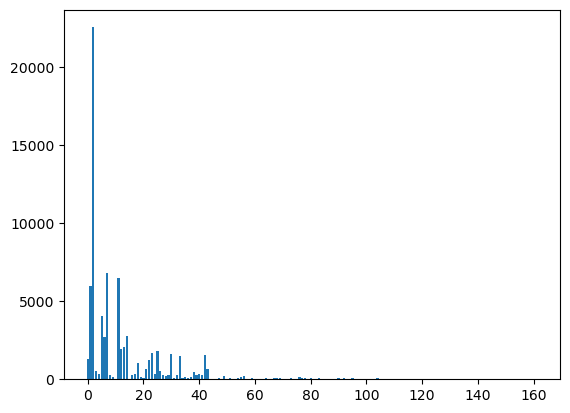

  Elapse_time for "prepare_data_2". It took 4.144443 seconds - 0hh:0mm:4ss.
 start time: Sep 07 2023 22:16:20  end time:  Sep 07 2023 22:16:25
Build model for adj_typ smote; len  of y_train = 2554740, len  of B_train = 2554740
Training starts for test_size = 0.3, c_parm = 100 


MemoryError: Unable to allocate 3.08 GiB for an array with shape (2554740, 162) and data type float64

In [45]:
l_c_parm = [0.1, 1, 10, 100] 
c_parm = 100 
l_embed_typ = ['tfidf', 'W2vec']

embed_typ = 'W2vec'
l_adj_typ= ['no_smote', 'smote', 'smote_under']
l_adj_typ= ['smote', 'smote_under']

dic_metric={}
dic_predict = {}
l_metric=[]
test_size = 0.3

i = 0
dte = date.today().strftime('%m%d%y')

for embed_typ in l_embed_typ:
    X, y, l1_l2_id_map, id_l1_l2_map = prepare_data_2(samp_frac = 0.3, embed_typ = embed_typ )
    for adj_typ in l_adj_typ:
        start_time = time.time()  
        
        preds, preds_lrtf, probs, preds_train, probs_train, lr_tf = proc_predict(test_size, c_parm, embed_typ, adj_typ)  
        test_metrics, vtab, l_metrics  =  validation(test_size, c_parm, embed_typ, adj_typ) 
        key = 'test_metric' + str(i)
        dic_metric [key] = (test_metrics, vtab)
        
        test_new_proobs, train_new_proobs, testLevels, testLevelss, trainLevelss = proc_append()
        df_save, ftab  = proc_cr_df(test_size, c_parm, embed_typ, adj_typ )
        key = 'predict'+ str(i)
        dic_predict[key] = (df_save, ftab)
        i = i + 1   
        end_time = time.time() 
        desc = f' Elapse_time to build model for for test_size = 0.3, c_parm = {c_parm}, embed_typ= {embed_typ}' 
        hh, mm, ss= elapse_time (  start_time, end_time, desc)
                                 
        l_metrics = l_metrics +  [f"{hh:2d}hh:{mm:2d}mm:{ss:2d}ss"]   
        l_metric.append(l_metrics)
                                  
excel_file = DBFO + f'L1_L2_syndigo_pred_cls_rpt_{adj_typ}_{dte}.xlsx'
save_excel_metric( excel_file, dic_metric, l_metric)


excel_file = DBFO + f'L1_L2_syndigo_pred_{adj_typ}_{dte}.xlsx'
save_excel_pred( excel_file, dic_predict)

In [ ]:
type(A_train)

In [35]:
len(y_train)

2554740

In [ ]:
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [28]:
# ValueError: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 6
# oversample = SMOTE(k_neighbors = 2) - Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 3
#  k_neighbors <= 2 NW) will get k_neighbors not defined
oversample = SMOTE(k_neighbors =0) # remove count < 3 from y 
X1, y1 = oversample.fit_resample(X, y)

InvalidParameterError: The 'k_neighbors' parameter of SMOTE must be an int in the range [1, inf) or an object implementing 'kneighbors' and 'kneighbors_graph'. Got 0 instead.

In [ ]:
# ValueError: "sampling_strategy" can be a float only when the type of target is binary. For multi-class, use a dict.
from imblearn.pipeline import Pipeline# ValueError: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 6
# oversample = SMOTE(k_neighbors = 2) - Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 3
#  k_neighbors <= 2 NW) will get k_neighbors not defined
oversample = SMOTE(k_neighbors =2) # remove count < 3 from y 
X1, y1 = oversample.fit_resample(X, y)
#over = SMOTE(sampling_strategy=0.1)
#under = RandomUnderSampler(sampling_strategy=0.5)
over = SMOTE(k_neighbors = 2)
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X2, y2 = pipeline.fit_resample(X, y)

In [ ]:
# oversample - = SMOTE(k_neighbors =3)  -ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 4
# oversample = SMOTE(k_neighbors = 2) - Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 3
#  k_neighbors <= 2 NW) will get k_neighbors not defined
oversample = SMOTE(k_neighbors =1) # remove count < 3 from y 
X3, y3 = oversample.fit_resample(X, y)

In [ ]:
# evaluate a model
def evaluate_model(X, y, model):
 # define evaluation procedure
 cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
 # evaluate model
 #scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
 scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
 return scores

In [ ]:
# define the model - numpy.core._exceptions._ArrayMemoryError: Unable to allocate 61.8 MiB for an array with shape (50000, 162) and data type float64
c_parm = 100
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
model = LogisticRegression(C = c_parm, multi_class = 'multinomial', solver = 'saga', n_jobs=-1)
#model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('ROc_AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [ ]:
# define the model
c_parm = 100

model1 = LogisticRegression(C = c_parm, multi_class = 'multinomial', solver = 'saga', n_jobs=-1)
#model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
# evaluate the model
scores1 = evaluate_model(X1, y1, model1)
# summarize performance
print('ROc_AUC: %.3f (%.3f)' % (np.mean(scores1), np.std(scores1)))

In [ ]:
model3 = LogisticRegression(C = c_parm, multi_class = 'multinomial', solver = 'saga', n_jobs=-1)
#model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
# evaluate the model
scores3 = evaluate_model(X3, y3, model3)
# summarize performance
print('ROc_AUC: %.3f (%.3f)' % (np.mean(scores2), np.std(scores2)))

In [ ]:
model2 = LogisticRegression(C = c_parm, multi_class = 'multinomial', solver = 'saga', n_jobs=-1)
#model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
# evaluate the model
scores2 = evaluate_model(X2, y2, model2)
# summarize performance
print('ROc_AUC: %.3f (%.3f)' % (np.mean(scores2), np.std(scores2)))

In [ ]:
print('ROc_AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [ ]:
# NW
for label, _ in counter.items():
 row_ix = where(y == label)[0]
 pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()


In [ ]:
excel_file = DBFO + f'L1_L2_syndigo_pred_tst_size{test_size}_082527.xlsx'
save_excel( excel_file, dic_predict)

In [ ]:
dic_predict.items()

In [ ]:
test_size = 0.3 
excel_file = DBFO + f'L1_L2_syndigo_pred_cls_rpt_size{test_size}_082527.xlsx'
save_excel_metric( excel_file, dic_metric, l_metric)


excel_file = DBFO + f'L1_L2_syndigo_pred_tst_size{test_size}_082527.xlsx'
save_excel_pred( excel_file, dic_predict)

In [ ]:
multi_class = 'multinomial'
score = roc_auc_score(y_test, preds, multi_class= multi_class)
print(f"ROC AUC score for Multiclass= {multi_class}: {score:.2f}")

In [ ]:
pim_gtin_mapped.columns

In [ ]:
pim_gtin_mapped.head()

In [ ]:
pim_gtin_mapped['ITM_ID_y'].value_counts(dropna = False)

In [ ]:
4823143/len(pim_gtin_mapped)

In [ ]:
type(l1_l2_id_map)

In [ ]:
df_dict = pd.DataFrame.from_dict(id_l1_l2_map, orient ='index', columns=['l1_l2']) 
df_dict.head()

In [ ]:
df_dict = df_dict.rename_axis('value').reset_index()
df_dict

In [ ]:
df_dict = pd.DataFrame.from_dict(id_l1_l2_map, orient ='index', columns=['l1_l2']).reset_index() 
df_dict.head()

In [ ]:
path = 'C:\\users\\iny2819\\kroger\\Data\\'
df_dict.to_csv(path + "id_l1_l2_map.csv", index=None)

In [ ]:
df_dict_1 = pd.DataFrame.from_dict(id_l1_l2_map)  #  If using all scalar values, you must pass an index
df_dict_1.head()

In [ ]:
l1_l2_id_map.items()

In [ ]:
len(y)

In [ ]:
y.value_counts(dropna = False)

In [ ]:
print(f' Count for y before smote {y.value_counts(dropna = False).sort_index()}') 

In [42]:
len(y)    # 77637
#len(y1)  # 3649698
#len(y2)  # 3649698

77637

In [43]:
type(X_train) 
#z = pd.Series(list(filter (lambda z: y_list.count(z) > 1, y_list)))

scipy.sparse._csr.csr_matrix

In [ ]:
series = syndigo_mapped[syndigo_mapped['l1_l2'].value_counts(ascending=True)
if series.tolist():
    subset_df = syndigo_mappeddrop(subset_df[subset_df['Level 2'].isin(series[series==1].index.tolist())].index)

In [ ]:
syndigo_mapped.columns

In [ ]:
len('W2vec_L1_L2_smote_under')

In [ ]:
syndigo_mapped['COM_DSC'].value_counts()

In [ ]:
series = syndigo_mapped['l1_l2'].value_counts(ascending=True)

In [ ]:
series = syndigo_mapped[syndigo_mapped['COM_DSC']]

In [ ]:
6      74863
1      22727
12     21240
5      19935
20     13582
0       9018
2       8928
25      7114
15      6296
3       6123
7       5729
21      5333
19      5048
9       4940
14      4483
13      3976
30      3557
41      2150
17      2082
10      1772
44      1649
32      1623
24      1232
11      1224
72      1157
23      1139
27       964
34       950
29       937
99       925
4        875
22       863
35       843
38       651
53       589
42       574
87       559
50       559
16       540
18       505
83       416
48       407
63       394
69       384
52       372
58       370
84       347
28       328
33       312
65       309
90       294
74       270
70       259
75       258
45       258
40       245
43       237
47       215
31       202
78       191
8        171
62       167
36       165
61       164
79       164
100      155
85       138
55       135
67       133
37       132
49       113
73       111
114      110
76       109
46       108
121      106
88       103
57        99
80        98
105       97
96        95
60        87
77        84
113       82
81        81
39        80
134       76
26        73
120       73
106       72
66        69
148       67
86        65
169       63
158       61
139       58
123       55
122       49
108       48
64        48
93        48
117       46
149       45
110       45
143       45
151       42
92        42
115       41
125       40
56        38
51        38
129       36
109       35
130       33
59        31
103       29
112       29
177       29
176       29
172       28
128       27
89        27
116       26
173       26
54        26
107       25
136       24
111       23
168       23
102       23
181       23
126       22
153       22
159       22
178       22
199       21
124       20
167       19
187       17
118       17
94        16
137       15
179       14
171       14
221       14
150       13
97        13
200       13
101       12
156       12
180       12
204       12
135       12
104       11
160       11
207       10
227       10
170        9
163        9
259        9
183        8
95         8
98         8
161        8
132        8
71         7
185        7
234        7
249        7
202        7
253        7
154        6
236        6
232        6
188        6
175        6
142        6
141        6
165        6
82         6
205        6
194        5
131        5
196        5
144        5
174        5
233        5
155        5
157        5
166        5
229        4
230        4
201        4
218        4
214        4
208        4
231        4
206        4
182        4
195        4
192        4
162        3
210        3
262        3
186        3
133        3
217        3
216        3
152        3
225        3
266        3
245        3
197        3
270        3
256        2
239        2
241        2
235        2
147        2
242        2
255        2
228        2
164        2
91         2
252        2
271        2
212        2
189        2
269        2
268        2
193        2
119        2
191        2
261        1
251        1
254        1
250        1
267        1
257        1
273        1
258        1
265        1
272        1
264        1
277        1
276        1
275        1
274        1
263        1
260        1
220        1
248        1
247        1
146        1
145        1
140        1
138        1
184        1
190        1
198        1
127        1
68         1
203        1
209        1
211        1
213        1
215        1
219        1
222        1
223        1
224        1
226        1
237        1
238        1
240        1
243        1
244        1
246        1
278        1